In [1]:
import json
import random
import tqdm
from tqdm import tqdm

import numpy as np
import pandas as pd

In [2]:
train = []
with open("../data/citation_generation/train.jsonl", "r") as f:
    for i, line in tqdm(enumerate(f)):
        row = json.loads(line)
        train.append(row)
        
        if i == 100: break

train = pd.DataFrame(train)
display(train.head())

100it [00:00, 8616.25it/s]


,citation_sentence,manuscript_id,cited_id,manuscript_text,cited_text
0,Such a discrepancy may likely be due to dose-o...,8281923,6704669,"[, Two earlier studies have reported that male...","[{'section': '', 'text': '3,4-Methylenedioxyme..."
1,"Similar to earlier observations (42) , the inf...",11155963,4009171,"[, Cell membrane scrambling, a hallmark of ery...","[{'section': '', 'text': 'Plasmodium falciparu..."
2,"In a cohort study in Korea (20) , the highest ...",11158470,15153392,"[During 1,288,820 person-years of follow-up (a...","[{'section': '', 'text': 'Several previous stu..."
3,This finding can be explained by the fact that...,11159272,14840523,[Static pressure profiles are shown in Fig. 3 ...,"[{'section': '', 'text': 'A therosclerosis occ..."
4,"However, the result of CFD simulation in this ...",11159272,13786003,[Static pressure profiles are shown in Fig. 3 ...,"[{'section': '', 'text': 'lesions therefore fa..."


In [3]:
# sentence tokenizer 
from nltk.tokenize.punkt import PunktSentenceTokenizer, PunktParameters

# tokenizer should not split at abbrieviations
abbreviations = ["i.e", "e.g", "etc", "al", "fig", "figs", "ref", "refs"]
abbreviations.extend([chr(x) for x in range(97,123)])
punkt_params = PunktParameters()
punkt_params.abbrev_types = set(abbreviations) 

# initialise sentence tokenizer
tokenizer = PunktSentenceTokenizer(punkt_params)

In [4]:
# sentence embedding model
import sent2vec

model = sent2vec.Sent2vecModel()
model.load_model("../sent2vec/wiki_unigrams.bin")

In [5]:
# similarity metric
from sklearn.metrics.pairwise import cosine_similarity

In [6]:
# ROUGE scorer
from rouge_score import rouge_scorer

rouge_N = ["rouge1", "rouge2", "rougeL"]
scorer = rouge_scorer.RougeScorer(rouge_N, use_stemmer=True)

def get_rouge_scores(gold_texts, query_texts):
    all_scores = []
    
    for gold, query in zip(gold_texts, query_texts):
        scores = list(scorer.score(gold, query).values())
        all_scores.append(scores)

    return np.array(all_scores)

In [7]:
# IDEA: combine sentences that are very short/have weird ending punctuation marks with previous sentence?
def combine_short_sentences_with_previous(sentences, min_length=5):
    all_long = all(len(s.split()) > min_length for s in sentences[1:])
    
    while not all_long:
        new_sentences = []
        for j, s in enumerate(sentences): 
            if j == 0: 
                new_sentences.append(s)
            elif s[-1] not in set([".", "?", "!"]) or len(s.split()) <= min_length:
                new_sentences[-1] += s
            else:
                new_sentences.append(s)
               
        all_long = all(map(lambda s: len(s.split()) > min_length, new_sentences[1:]))
        sentences = new_sentences
    
    return sentences

## A. Retrieve sentence pairs with highest similarity scores 

- "brute-force" approach: 
    - for each sentence pair from (manuscript_sentences, cited_sentences), 
    - compute their cosine similarity 
    - return the sentence pairs that attain the highest similarity scores

In [45]:
def get_topk_pairs(manuscript_text, cited_text, k=5): 
    manuscript_sentences = combine_short_sentences_with_previous(tokenizer.tokenize(manuscript_text))
    cited_sentences = combine_short_sentences_with_previous(tokenizer.tokenize(cited_text))
    
    if len(manuscript_sentences) < k or len(cited_sentences) < k:
        return []
    
    manuscript_embeddings = model.embed_sentences(manuscript_sentences)
    cited_embeddings = model.embed_sentences(cited_sentences)
    similarity = cosine_similarity(manuscript_embeddings, cited_embeddings)
    
    indices = np.argpartition(similarity, kth=-k, axis=None)[-k:]
    indices = np.flip(indices[np.argsort(similarity.flatten()[indices])])
    topk_similarity = similarity.flatten()[indices]

    manuscript_indices = indices % similarity.shape[0]
    cited_indices = indices % similarity.shape[1]
    
    topk_manuscript_sentences = [manuscript_sentences[i] for i in manuscript_indices]
    topk_cited_sentences = [cited_sentences[i] for i in cited_indices]
    
    return list(zip(topk_similarity, topk_manuscript_sentences, topk_cited_sentences))

In [66]:
# apply method_A on train
method_A = train.copy()
all_topk_pairs = []
for _, row in method_A.iterrows():
    topk_pairs = get_topk_pairs(
        " ".join(row.manuscript_text).lower(), 
        " ".join(para["text"] for para in row.cited_text).lower(), 
        k=5
    )
    all_topk_pairs.append(topk_pairs)
    
method_A["topk_pairs"] = all_topk_pairs

In [67]:
# some rows have manuscript_texts that are very short 
display(method_A[method_A.topk_pairs.apply(lambda p: p == [])])

method_A = method_A[method_A.topk_pairs.apply(lambda p: p != [])]

,citation_sentence,manuscript_id,cited_id,manuscript_text,cited_text,topk_pairs
26,Various results were obtained from the studies...,22685229,14053509,"[In this study, a total of 3366 clinical sampl...","[{'section': '', 'text': 'Pseudomonas aerugino...",[]
27,In many studies conducted on patients with imm...,22685229,18780913,"[In this study, a total of 3366 clinical sampl...","[{'section': 'Introduction', 'text': 'Infectio...",[]
40,"According to the authors, this review confirme...",37027814,20358884,[Sixty-five (71.4%) events started while child...,"[{'section': '', 'text': 'A n apparent life th...",[]
67,Our previous results show that the trend direc...,10871089,12198745,[Younger employees with higher education had l...,"[{'section': '', 'text': 'Sickness absence (SA...",[]


### B. Back-and-forth search?

- get manuscript_sentences that are closest to the cited_paper (as a whole)
- get cited_sentences that are closest to the concatenation of the selected manuscript_sentences

In [76]:
def get_topk_sentences(query_text, refer_text, k=5):
    """
    Retrieve k sentences from query_text that are most similar to refer_text
    """
    
    query_sentences = combine_short_sentences_with_previous(
        tokenizer.tokenize(query_text))
    if len(query_sentences) < k or refer_text == "": 
        return []
    
    query_embeddings = model.embed_sentences(query_sentences)
    refer_embedding = model.embed_sentence(refer_text)
    
    similarity = cosine_similarity(query_embeddings, refer_embedding).flatten()
    
    indices = np.argpartition(similarity, kth=-k)[-k:]
    indices = np.flip(indices[np.argsort(similarity[indices])])
    topk_similarity = similarity[indices]
    
    topk_query_sentences = [query_sentences[i] for i in indices]
    return list(zip(topk_similarity, topk_query_sentences))

In [77]:
method_B = train.copy()

all_topk_manuscript_sentences = []
all_topk_cited_sentences = []
for i, row in method_B.iterrows():
    manuscript_text = " ".join(row.manuscript_text).lower()
    cited_text = " ".join([para["text"] for para in row.cited_text]).lower()
        
    topk_manuscript_sentences = get_topk_sentences(manuscript_text, cited_text)
    all_topk_manuscript_sentences.append(topk_manuscript_sentences)
    
    topk_cited_sentences = get_topk_sentences(
        cited_text, " ".join([p[1] for p in topk_manuscript_sentences])
    )
    all_topk_cited_sentences.append(topk_cited_sentences)

method_B["topk_manuscript_sentences"] = all_topk_manuscript_sentences
method_B["topk_cited_sentences"] = all_topk_cited_sentences

In [86]:
# some rows have manuscript_texts that are very short 
display(method_B[method_B.topk_manuscript_sentences.apply(lambda p: p == [])])

method_B = method_B[method_B.topk_manuscript_sentences.apply(lambda p: p != [])]

,citation_sentence,manuscript_id,cited_id,manuscript_text,cited_text,topk_manuscript_sentences,topk_cited_sentences
26,Various results were obtained from the studies...,22685229,14053509,"[In this study, a total of 3366 clinical sampl...","[{'section': '', 'text': 'Pseudomonas aerugino...",[],[]
27,In many studies conducted on patients with imm...,22685229,18780913,"[In this study, a total of 3366 clinical sampl...","[{'section': 'Introduction', 'text': 'Infectio...",[],[]
40,"According to the authors, this review confirme...",37027814,20358884,[Sixty-five (71.4%) events started while child...,"[{'section': '', 'text': 'A n apparent life th...",[],[]
67,Our previous results show that the trend direc...,10871089,12198745,[Younger employees with higher education had l...,"[{'section': '', 'text': 'Sickness absence (SA...",[],[]


## Results

In [137]:
# compute ROUGE scores of extracted cited_sentences against citation_sentence
all_scores_A = get_rouge_scores(
    method_A.citation_sentence, 
    [" ".join([p[2] for p in row]) for row in method_A.topk_pairs]
)

In [138]:
# compute ROUGE scores of extracted cited_sentences against citation_sentence
all_scores_B = get_rouge_scores(
    method_B.citation_sentence, 
    [" ".join([p[1] for p in row]) for row in method_B.topk_cited_sentences]
)

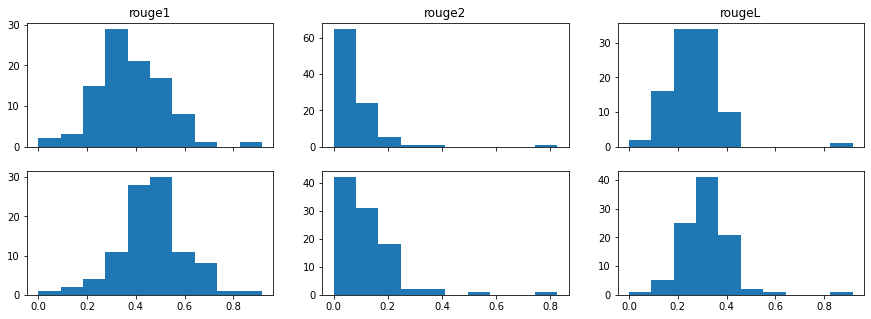

In [119]:
import matplotlib.pyplot as plt

f, axes = plt.subplots(2, 3, figsize=(15,5), sharex="col")
for i in range(3):
    key = rouge_N[i]
    axes[0][i].hist(all_scores_A[:,i,1])
    axes[0][i].title.set_text(key)
    
for i in range(3):
    key = rouge_N[i]
    axes[1][i].hist(all_scores_B[:,i,1])

plt.show()

In [143]:
for i in range(3):
    print(all_scores_A[:,i,1].argmax(), round(all_scores_A[:,i,1].max(), 5))
print()

for i in range(3):
    print(all_scores_B[:,i,1].argmax(), round(all_scores_B[:,i,1].max(), 5))

88 0.91667
88 0.82609
88 0.91667

88 0.91667
88 0.82609
88 0.91667


In [122]:
# method_A with highest ROUGE-1 score
x = all_scores_A[:,0,1].argmax()
row = method_A.loc[x]

print(all_scores_A[x,0,1])
print(row.citation_sentence+"\n")

for p in row.topk_pairs:
    print(p[0])
    print(f"[m]: {p[1]}\n[c]: {p[2]}\n")

0.9166666666666666
Second, we found a lower incidence of VAP with the use of a continuous cuff-pressure control system in the MLRA, not only in the Kaplan-Meier analysis as in the study by Nseir et al. [11] .

0.67276275
[m]: there were no significant differences between the two groups of patients (150 with the intermittent and 134 with continuous cuff-pressure control system) in terms of sex, age, smoking status, chronic obstructive pulmonary disease, diabetes mellitus, chemotherapeutic agents, steroid agents, hematological tumor, solid tumor, diagnosis group, apache-ii score, duration of mechanical ventilation, antibiotics prior to vap onset, use of paralytic agents, tracheotomy, reintubation, enteral nutrition, ssd or icu mortality (table 1 ).
[c]: percentage of patients with p cuff less than 20 cm h 2 o, percentage of patients with p cuff greater than 30 cm h 2 o, percentage of p cuff determinations less than 20 cm h 2 o, and percentage of p cuff determinations greater than 30 cm h

In [117]:
# method_B with highest ROUGE-1 score
x = all_scores_B[:,0,1].argmax()
row = method_B.loc[x]

print(all_scores_B[x,0,1])
print(row.citation_sentence+"\n")
for p in row.topk_cited_sentences:
    print(p[0])
    print(f"[c]: {p[1]}\n")

0.9166666666666666
Second, we found a lower incidence of VAP with the use of a continuous cuff-pressure control system in the MLRA, not only in the Kaplan-Meier analysis as in the study by Nseir et al. [11] .

0.67088246
[c]: implementation of this measure should now be considered in icus with high vap rates even if randomized controlled multicenter studies are needed to confirm our results and to evaluate costeffectiveness and long-term effect of continuous control of p cuff on tracheal ischemic lesions before generalizing the use of this technique in every intubated patient requiring mechanical ventilation.author disclosure: s.n.

0.63120687
[c]: however, continuous control of p cuff had no significant effect on the incidence of tracheal ischemic lesions.

0.6117127
[c]: most episodes of vap were late onset (77% [17 of 22] ); no significant difference was found in rate of patients with late-onset vap between intervention and control group (83 vs.75%, p ¼ 0.115).

0.60309505
[c]: alth

In [167]:
# try removing this row 88 to see what happens 
method_A_subset = method_A.drop(method_A.index[88])
all_scores_A_subset = np.delete(all_scores_A, 88, 0)
for i in range(3):
    print(all_scores_A_subset[:,i,1].argmax(), round(all_scores_A_subset[:,i,1].max(), 5))
print()
    
method_B_subset = method_B.drop(method_B.index[88])
all_scores_B_subset = np.delete(all_scores_B, 88, 0)
for i in range(3):
    print(all_scores_B_subset[:,i,1].argmax(), round(all_scores_B_subset[:,i,1].max(), 5))

35 0.67647
53 0.39286
30 0.44444

53 0.75862
53 0.5
53 0.58621


- with method_A, different samples achieve the highest ROUGE-1, ROUGE-2, ROUGE-L scores
- with method_B, this sentence achieves highest ROUGE-1, ROUGE-2, ROUGE-L scores

In [166]:
# peek at row 53 (best for ROUGE-2)
x = all_scores_A_subset[:,1,1].argmax()
row = method_A_subset.loc[x]

print(all_scores_A_subset[x,1,1])
print(row.citation_sentence+"\n")

for p in row.topk_pairs:
    print(p[0])
    print(f"[m]: {p[1]}\n[c]: {p[2]}\n")

0.39285714285714285
The sparing of social discrimination and strong expression of mother preference at both 3 and 6 months of age in amygdalectomized infants in the present study did differ from the weaker mother preference previously reported at 6 months in mother-reared amygdalectomized infants (Bauman et al., 2004) .

0.73362255
[m]: table 1 displays that the discriminant functions accurately classified 84% (3 months) and 85% (6 months) of the monkeys into their actual groups and this value differed significantly from chance as assessed by the press's q tests (q=11.56, df=1, p<.001, and q = 9.8, df=1, p<.001, respectively).
[c]: importantly, affiliative vocalizations did not reveal any lesion effect (coos: f (2,21) ϭ 0.699, p ϭ 0.5082; grunts: f (2,21) ϭ 0.823, p ϭ 0.4529; barks: f (2,21) ϭ 1.028, p ϭ 0.3750).

0.6773118
[m]: table 1 displays that the discriminant functions accurately classified 84% (3 months) and 85% (6 months) of the monkeys into their actual groups and this value

- not all sentences seem related to the citation_sentence (esp. first and third)

In [168]:
# peek at row 53 (method_B)
x = all_scores_B_subset[:,0,1].argmax()
row = method_B_subset.loc[x]

print(all_scores_B_subset[x,0,1])
print(row.citation_sentence+"\n")

for p in row.topk_cited_sentences:
    print(p[0])
    print(f"[c]: {p[1]}\n")

0.7586206896551724
The sparing of social discrimination and strong expression of mother preference at both 3 and 6 months of age in amygdalectomized infants in the present study did differ from the weaker mother preference previously reported at 6 months in mother-reared amygdalectomized infants (Bauman et al., 2004) .

0.643356
[c]: however, overall activity levels, as measured by the number of times the infant crossed the midline of the cage, indicated that the hippocampuslesioned infants displayed more locomotor behavior than the other groups (f (2,21) ϭ 3.72; p ϭ 0.0414; hippocampus ͼ control ϭ amygdala; p ϭ 0.0450 and 0.0191, respectively).

0.6431742
[c]: preference was evaluated based on measures of time spent in proximity to the mother or the stimulus female (scored only if the infant remained within 1 m of its mother or the stimulus female for at least 3 sec), the average distance from its mother or the stimulus female, and the frequency and durations of species-typical behavi

- extracted cited_sentences share many keywords with the citation_sentence
    - "mother preference", "amydalectomized, amygdala"
- however, extracted cited_sentences do not suggest that "mother-reared amygdalectomized infants" show "weaker mother preference"

- 3/5 of these cited_sentences were also picked up by method_A
    - however, at least all five sentences here look quite related to citation_sentence 
    - ROUGE score attained via method_B is also higher